# LSTM — Predict GHS Buying Price vs USD

This notebook implements an LSTM pipeline to predict the `Buying` price (GHS) against the US Dollar. Steps:
- Load dataset (`merged_fx_dataset.csv`)
- Basic EDA and missing value checks
- Correlation-based feature dropping (drop one of highly correlated features when they don't correlate with the target)
- Preprocessing: scaling, sequence creation
- Build, train and evaluate an LSTM model

Notes:
- Target column: `Buying`
- Date column: `Date` (parsed to datetime)
- The notebook will try `datasets/cleaned/merged_fx_dataset.csv` first, then `merged_fx_dataset.csv` in the root.

In [4]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math

# plt.style.use('rocket')
%matplotlib inline

In [5]:
# Load dataset (try cleaned path first)
path = 'datasets/cleaned/merged_fx_dataset.csv'
df = pd.read_csv(path)
print(f'Loaded {path} with shape', df.shape)

Loaded datasets/cleaned/merged_fx_dataset.csv with shape (3703, 27)


In [6]:
# Ensure Date parsed and sorted
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
# Quick peek
df.head()

,Date,Buying,Selling,MidRate,MPR,FoodInflation,GhInflationRate,NonFoodInflation,BrentOil,Cocoa,...,GhCompositeIndex,FXDeposits,InterbankWeightedAvg,T-bill-182,T-bill-91,PrivateSectorCredit,TradeBalance,USGDP,USInflationRate,USInterestRate
0,2008-01-02,0.9545,0.9799,0.9672,13.5,10.64,12.81,14.4,91.9,2174.5,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.11
1,2008-01-03,0.9545,0.9799,0.9672,13.5,10.64,12.81,14.4,91.9,2174.5,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.25
2,2008-01-04,0.9543,0.9798,0.9671,13.5,10.64,12.81,14.4,91.9,2174.5,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.18
3,2008-01-07,0.9551,0.9809,0.9680,13.5,10.64,12.81,14.4,91.9,2174.5,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.27
4,2008-01-08,0.9576,0.9800,0.9688,13.5,10.64,12.81,14.4,91.9,2174.5,...,25.89,1127.98,12.16,11.03,10.72,3336.9,-417.88,16843.003,87.093,4.27


In [7]:
# Basic info and missing values
print(df.info())
display(df.describe())
print('Missing values per column:')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  3703 non-null   datetime64[ns]
 1   Buying                3703 non-null   float64       
 2   Selling               3701 non-null   float64       
 3   MidRate               3701 non-null   float64       
 4   MPR                   3703 non-null   float64       
 5   FoodInflation         3703 non-null   float64       
 6   GhInflationRate       3703 non-null   float64       
 7   NonFoodInflation      3703 non-null   float64       
 8   BrentOil              3703 non-null   float64       
 9   Cocoa                 3703 non-null   float64       
 10  Gold                  3703 non-null   float64       
 11  GhInterestRate        3703 non-null   float64       
 12  NetForeignAssets      3703 non-null   float64       
 13  NIR               

,Date,Buying,Selling,MidRate,MPR,FoodInflation,GhInflationRate,NonFoodInflation,BrentOil,Cocoa,...,GhCompositeIndex,FXDeposits,InterbankWeightedAvg,T-bill-182,T-bill-91,PrivateSectorCredit,TradeBalance,USGDP,USInflationRate,USInterestRate
count,3703,3703.000000,3701.000000,3701.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,...,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000
mean,2015-06-16 19:20:47.312989440,3.530772,3.544903,3.538283,17.566298,9.406992,13.162123,15.904580,78.275919,2605.203195,...,10.724850,12890.848739,17.692960,18.781812,18.092925,23971.175385,-91.865903,18832.657882,97.836017,0.675963
min,2008-01-02 00:00:00,0.000000,0.000000,0.000000,12.500000,-1.630000,4.670000,6.740000,26.625700,1904.600000,...,-10.470000,1127.980000,6.350000,9.900000,9.250000,3336.900000,-733.060000,16269.145000,87.093000,0.040000
25%,2011-09-21 00:00:00,1.506600,1.540600,1.521500,14.500000,5.330000,8.640000,11.210000,56.000000,2324.818200,...,2.920000,3791.390000,13.570000,13.830000,13.190000,7943.450000,-262.620000,17035.114000,91.570000,0.090000
50%,2015-06-17 00:00:00,3.779600,3.783400,3.781500,16.000000,7.350000,11.410000,14.240000,74.800000,2555.860000,...,6.220000,11166.070000,16.840000,16.190000,15.510000,24659.580000,-108.860000,18782.243000,96.882000,0.160000
75%,2019-03-12 12:00:00,5.082800,5.087900,5.085400,19.000000,11.470000,16.910000,20.570000,105.810000,2897.600000,...,13.900000,18305.780000,22.110000,24.620000,23.070000,33986.980000,88.000000,20304.874000,103.058000,1.160000
max,2022-12-01 00:00:00,13.099100,13.112300,13.105700,27.000000,59.700000,54.100000,49.900000,134.800000,3430.400000,...,73.360000,66496.630000,25.800000,36.230000,35.480000,73744.050000,666.990000,22249.459000,116.977000,4.270000
std,NaN,2.075334,2.067895,2.071712,3.887258,7.649873,6.548326,6.722725,26.067664,364.240950,...,14.042634,11516.004255,4.783674,5.994375,5.712537,16068.639877,259.873020,1767.190952,7.435416,0.884789


Missing values per column:
Date                    0
Buying                  0
Selling                 2
MidRate                 2
MPR                     0
FoodInflation           0
GhInflationRate         0
NonFoodInflation        0
BrentOil                0
Cocoa                   0
Gold                    0
GhInterestRate          0
NetForeignAssets        0
NIR                     0
Imports                 0
Exports                 0
GhGDP                   0
GhCompositeIndex        0
FXDeposits              0
InterbankWeightedAvg    0
T-bill-182              0
T-bill-91               0
PrivateSectorCredit     0
TradeBalance            0
USGDP                   0
USInflationRate         0
USInterestRate          0
dtype: int64


In [8]:
df['Buying'] = df['Buying'].replace(0, np.nan)
df['Buying'] = df['Buying'].interpolate()

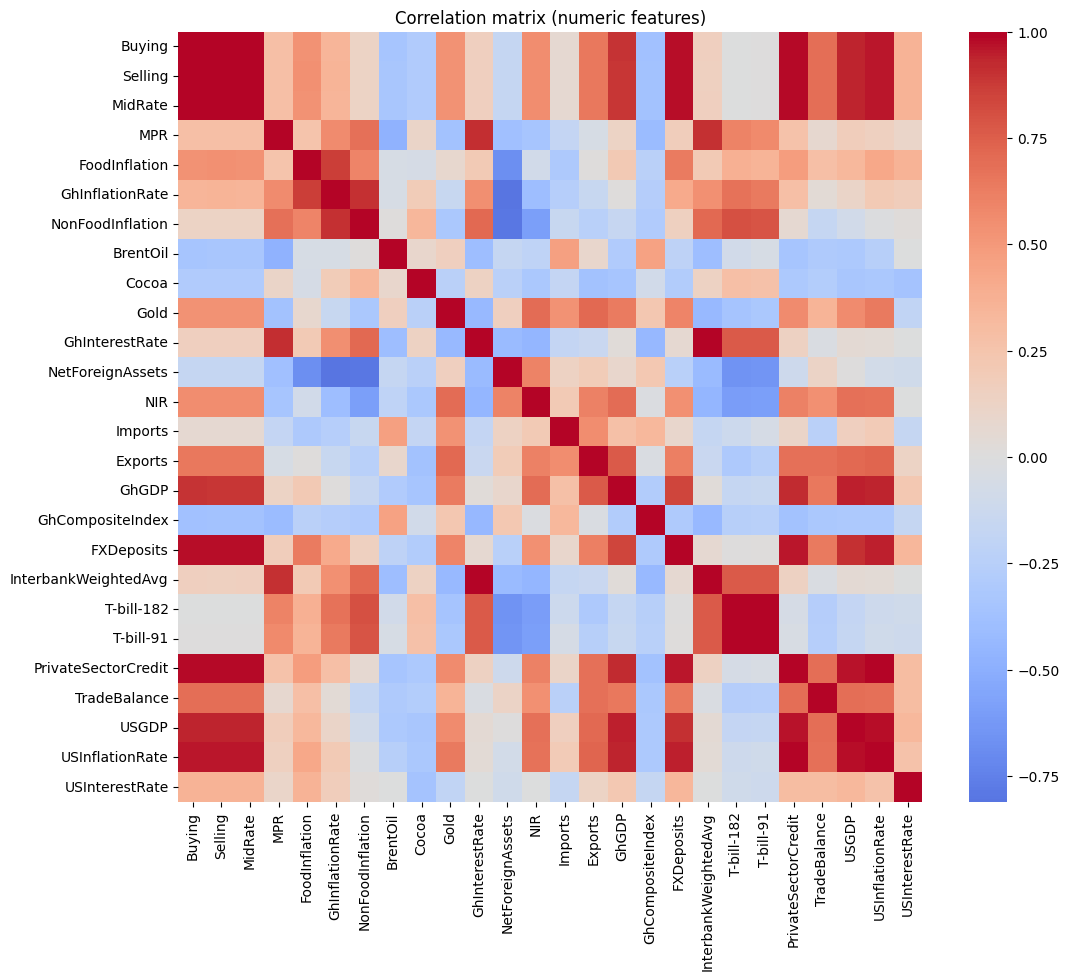

In [9]:
# Correlation matrix (numeric columns)
numeric = df.select_dtypes(include=[np.number]).copy()
corr = numeric.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation matrix (numeric features)')
plt.show()

In [10]:
# Correlation-based feature dropping
target = 'Buying'
if target not in numeric.columns:
    raise KeyError(f'Target column {target} not found in numeric columns')

# Parameters: highly correlated pairs threshold and low target-correlation threshold
high_corr_thresh = 0.9
low_target_corr_thresh = 0.2

to_drop = set()
cols = numeric.columns.tolist()
# Examine upper triangle pairs
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        c1 = cols[i]
        c2 = cols[j]
        if abs(corr.loc[c1, c2]) >= high_corr_thresh:
            # If both have low corr with target, drop the one with lower abs corr with target (or higher missing)
            corr1 = abs(numeric[c1].corr(numeric[target]))
            corr2 = abs(numeric[c2].corr(numeric[target]))
            if corr1 < low_target_corr_thresh and corr2 < low_target_corr_thresh:
                # pick one to drop
                drop_col = c1 if corr1 <= corr2 else c2
                to_drop.add(drop_col)
                print(f'Dropping {drop_col} since {c1} and {c2} correlate {corr.loc[c1,c2]:.3f} and both have low corr with target ({corr1:.3f}, {corr2:.3f})')

# Apply drops but ensure not to drop the target or Date
to_drop = [c for c in to_drop if c != target]
print('Columns to drop based on correlation rule:', to_drop)
df_reduced = df.drop(columns=to_drop) if to_drop else df.copy()

# Show remaining numeric cols
print('Remaining numeric columns:', df_reduced.select_dtypes(include=[np.number]).columns.tolist())

Dropping InterbankWeightedAvg since GhInterestRate and InterbankWeightedAvg correlate 0.999 and both have low corr with target (0.161, 0.159)
Dropping T-bill-182 since T-bill-182 and T-bill-91 correlate 0.990 and both have low corr with target (0.002, 0.007)
Columns to drop based on correlation rule: ['T-bill-182', 'InterbankWeightedAvg']
Remaining numeric columns: ['Buying', 'Selling', 'MidRate', 'MPR', 'FoodInflation', 'GhInflationRate', 'NonFoodInflation', 'BrentOil', 'Cocoa', 'Gold', 'GhInterestRate', 'NetForeignAssets', 'NIR', 'Imports', 'Exports', 'GhGDP', 'GhCompositeIndex', 'FXDeposits', 'T-bill-91', 'PrivateSectorCredit', 'TradeBalance', 'USGDP', 'USInflationRate', 'USInterestRate']


In [11]:
# Fill or drop missing values (simple strategy)
# We'll forward-fill then back-fill for time series consistency
df_reduced = df_reduced.sort_values('Date').reset_index(drop=True)
df_reduced = df_reduced.ffill().bfill()
print('Any missing left?', df_reduced.isna().sum().sum())

Any missing left? 0


## Preprocessing: scaling and sequence creation
We'll scale features with MinMaxScaler and create sequences with a lookback window (default 60). We'll perform a time-based split: first 80% for train, remaining 20% for test.

In [12]:
# Configuration
LOOKBACK = 20  # sequence length
TRAIN_RATIO = 0.8
feature_cols = [c for c in df_reduced.columns if c not in ['Date', target]]
print('Feature columns used:', feature_cols)

# Prepare arrays
data_values = df_reduced[feature_cols + [target]].values.astype(float)
dates = df_reduced['Date'].values

# Scale features and target separately (so we can inverse transform target)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_reduced[feature_cols])
y_scaled = scaler_y.fit_transform(df_reduced[[target]])

# Create sequences
def create_sequences(X, y, lookback=LOOKBACK):
    Xs, ys, idxs = [], [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
        idxs.append(i+lookback)
    return np.array(Xs), np.array(ys), np.array(idxs)

Xs, ys, idxs = create_sequences(X_scaled, y_scaled, LOOKBACK)
print('Sequences shape X:', Xs.shape, 'y:', ys.shape)

# Train/test split by index ordering
n_train = int(len(Xs) * TRAIN_RATIO)
X_train, X_test = Xs[:n_train], Xs[n_train:]
y_train, y_test = ys[:n_train], ys[n_train:]
idxs_train, idxs_test = idxs[:n_train], idxs[n_train:]
dates_train = dates[idxs_train]
dates_test = dates[idxs_test]
print('Train sequences:', X_train.shape, 'Test sequences:', X_test.shape)

Feature columns used: ['Selling', 'MidRate', 'MPR', 'FoodInflation', 'GhInflationRate', 'NonFoodInflation', 'BrentOil', 'Cocoa', 'Gold', 'GhInterestRate', 'NetForeignAssets', 'NIR', 'Imports', 'Exports', 'GhGDP', 'GhCompositeIndex', 'FXDeposits', 'T-bill-91', 'PrivateSectorCredit', 'TradeBalance', 'USGDP', 'USInflationRate', 'USInterestRate']
Sequences shape X: (3683, 20, 23) y: (3683, 1)
Train sequences: (2946, 20, 23) Test sequences: (737, 20, 23)


## Build and train LSTM model
We'll create a simple LSTM with one or two layers, dropout and early stopping. The model will predict the scaled `Buying` value.

In [11]:
# Model definition
n_features = X_train.shape[2]
model = Sequential([
    LSTM(64, input_shape=(LOOKBACK, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

# Callbacks
os.makedirs('models', exist_ok=True)
checkpoint_path = 'models/lstm_ghs_buying.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,641 (96.25 KB)

 Trainable params: 24,641 (96.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0147

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0051 - val_loss: 0.0340
Epoch 2/100
Epoch 2/100
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1332e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5720e-04 - val_loss: 0.0293
Epoch 3/100
Epoch 3/100
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1711e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1514e-04 - val_loss: 0.0228
Epoch 4/100
Epoch 4/100
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4767e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1302e-04 - val_loss: 0.0191
Epoch 5/100
Epoch 5/100
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5422e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4132e-04 - val_loss: 0.0189
Epoch 6/100
Epoch 6/100
85/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2266e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0313e-04 - val_loss: 0.0185
Epoch 7/100
Epoch 7/100
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6686e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6379e-04 - val_loss: 0.0166
Epoch 8/100
Epoch 8/100
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2378e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4427e-04 - val_loss: 0.0161
Epoch 9/100
Epoch 9/100
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7145e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4688e-04 - val_loss: 0.0160
Epoch 10/100
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4326e-04 - val_loss: 0.0185
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4326e-04 - val_loss: 0.0185
Epoch 11/100
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9801e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9141e-04 - val_loss: 0.0159
Epoch 12/100
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7471e-04 - val_loss: 0.0168
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7471e-04 - val_loss: 0.0168
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5349e-04 - val_loss: 0.0168
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5349e-04 - val_loss: 0.0168
Epoch 14/100
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5859e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5477e-04 - val_loss: 0.0151
Epoch 15/100
Epoch 15/100
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5295e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4757e-04 - val_loss: 0.0132
Epoch 16/100
Epoch 16/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5103e-04 - val_loss: 0.0160
Epoch 17/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5103e-04 - val_loss: 0.0160
Epoch 17/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2803e-04 - val_loss: 0.0155
Epoch 18/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2803e-04 - val_loss: 0.0155
Epoch 18/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3441e-04 - val_loss: 0.0159
Epoch 19/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3441e-04 - val_loss: 0.0159
Epoch 19/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0778e-04 - val_loss: 0.0137
Epoch 20/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0778e-04 - val_loss: 0.0137
Epoch 20/100
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0567e-04

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0417e-04 - val_loss: 0.0123
Epoch 21/100
Epoch 21/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1946e-04 - val_loss: 0.0155
Epoch 22/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1946e-04 - val_loss: 0.0155
Epoch 22/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0496e-04 - val_loss: 0.0137
Epoch 23/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0496e-04 - val_loss: 0.0137
Epoch 23/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0699e-05 - val_loss: 0.0133
Epoch 24/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0699e-05 - val_loss: 0.0133
Epoch 24/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2436e-04 - val_loss: 0.0172
Epoch 25/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2436e-04 - val_loss: 0.0172
Epoch 25/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3313e-04 - val_loss: 0.0162
Epoch 26/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3313e-04 - val_loss: 0.0162
Epoch 26/1

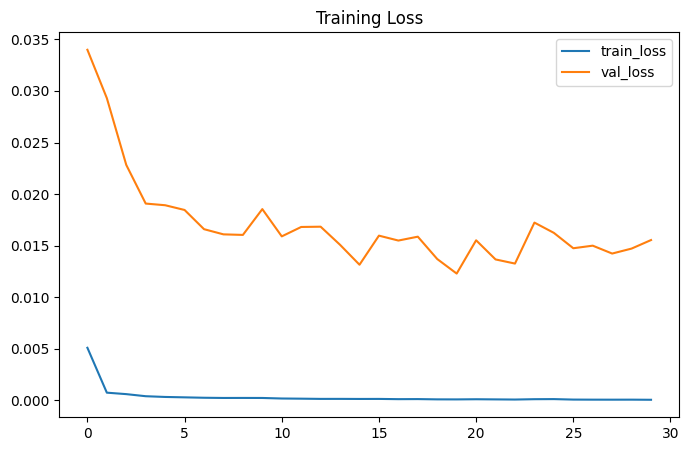

In [12]:
# Plot training history
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training Loss')
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


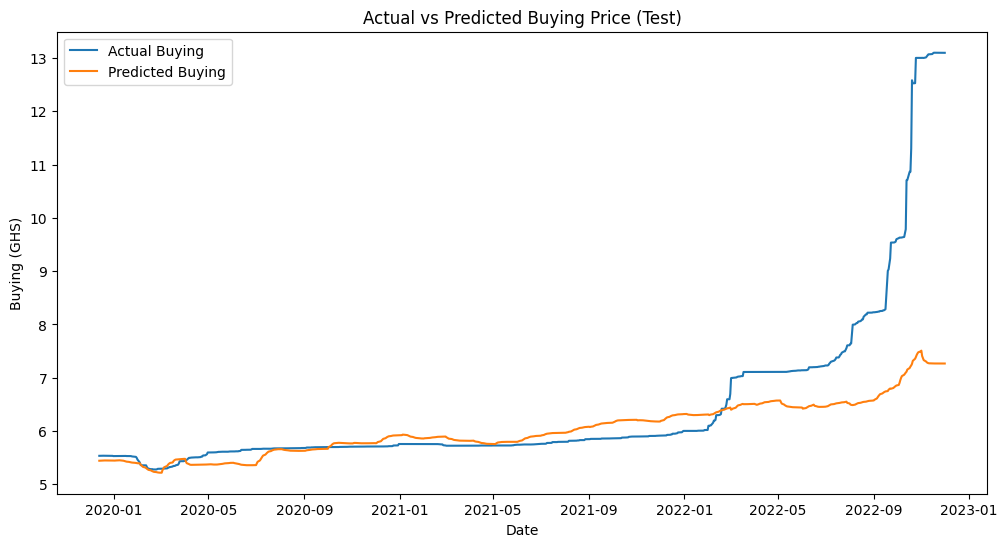

In [13]:
# Predictions and evaluation
y_pred_scaled = model.predict(X_test)
# Inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled)[:,0]
y_true = scaler_y.inverse_transform(y_test)[:,0]

# Plot actual vs predicted over test period
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_true, label='Actual Buying')
plt.plot(dates_test, y_pred, label='Predicted Buying')
plt.xlabel('Date')
plt.ylabel('Buying (GHS)')
plt.legend()
plt.title('Actual vs Predicted Buying Price (Test)')
plt.show()

## Notes and next steps
- Try different lookback windows (30, 60, 90)
- Tune LSTM size, number of layers, learning rate or try GRU/Bi-LSTM
- Add walk-forward validation for more robust time-series evaluation
- Consider feature engineering: lag features, rolling statistics, external macro variables

Requirements: ensure `requirements.txt` contains tensorflow, pandas, scikit-learn, matplotlib, seaborn if running in a fresh environment.

In [14]:
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2_Score = r2_score(y_true, y_pred)
print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2Score: {r2_Score:.4f}')

RMSE: 1.3469, MAE: 0.6008, R2Score: 0.3477


## Model Tuning

We'll systematically test different configurations:
1. Lookback periods (10, 30, 60, 90 days)
2. LSTM architectures (single layer, stacked, bidirectional)
3. Learning rates and optimizers
4. Regularization (dropout rates)

In [15]:
# Hyperparameter configurations
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import itertools

# Test configurations
lookback_periods = [10, 30, 60, 90]
lstm_configs = [
    ('single', [(64, False)]),  # (units, bidirectional)
    ('stacked', [(64, False), (32, False)]),
    ('bidirectional', [(64, True)])
]
learning_rates = [0.001, 0.0001]
dropout_rates = [0.2, 0.3]

# Results tracking
results = []

def create_model(lstm_config, n_features, lookback, dropout_rate, lr):
    model = Sequential()

    # Add LSTM layers according to config
    for i, (units, is_bidirectional) in enumerate(lstm_config):
        return_sequences = i < len(lstm_config) - 1  # True for all but last LSTM layer

        if is_bidirectional:
            lstm_layer = Bidirectional(
                LSTM(units, return_sequences=return_sequences),
                input_shape=(lookback, n_features) if i == 0 else None
            )
        else:
            lstm_layer = LSTM(
                units,
                return_sequences=return_sequences,
                input_shape=(lookback, n_features) if i == 0 else None
            )

        model.add(lstm_layer)
        model.add(Dropout(dropout_rate))

    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse'
    )
    return model

In [17]:
# Experiment loop
best_rmse = float('inf')
best_config = None

for lookback, (arch_name, lstm_config), lr, dropout in itertools.product(
    lookback_periods, lstm_configs, learning_rates, dropout_rates
):
    print(f"\nTesting configuration:")
    print(f"Lookback: {lookback}, Architecture: {arch_name}")
    print(f"Learning rate: {lr}, Dropout: {dropout}")

    # Create sequences for this lookback
    Xs, ys, idxs = create_sequences(X_scaled, y_scaled, lookback)
    n_train = int(len(Xs) * TRAIN_RATIO)
    X_train, X_test = Xs[:n_train], Xs[n_train:]
    y_train, y_test = ys[:n_train], ys[n_train:]

    # Create and train model
    model = create_model(lstm_config, X_train.shape[2], lookback, dropout, lr)

    # Add learning rate reduction
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=0  # Reduce output noise
    )

    # Evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)[:,0]
    y_true = scaler_y.inverse_transform(y_test)[:,0]

    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results.append({
        'lookback': lookback,
        'architecture': arch_name,
        'learning_rate': lr,
        'dropout': dropout,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'min_val_loss': min(history.history['val_loss'])
    })

    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_config = {
            'lookback': lookback,
            'architecture': arch_name,
            'learning_rate': lr,
            'dropout': dropout
        }
        # model.save(f'models/lstm_ghs_buying_best.h5')
        model.save('models/lstm_ghs_buying_best.keras')


# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('rmse')


Testing configuration:
Lookback: 10, Architecture: single
Learning rate: 0.001, Dropout: 0.2


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
RMSE: 1.1843, MAE: 0.5161, R2: 0.4948

Testing configuration:
Lookback: 10, Architecture: single
Learning rate: 0.001, Dropout: 0.3
RMSE: 1.1843, MAE: 0.5161, R2: 0.4948

Testing configuration:
Lookback: 10, Architecture: single
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
RMSE: 1.2991, MAE: 0.6328, R2: 0.3921

Testing configuration:
Lookback: 10, Architecture: single
Learning rate: 0.0001, Dropout: 0.2
RMSE: 1.2991, MAE: 0.6328, R2: 0.3921

Testing configuration:
Lookback: 10, Architecture: single
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 0.9418, MAE: 0.5692, R2: 0.6805

Testing configuration:
Lookback: 10, Architecture: single
Learning rate: 0.0001, Dropout: 0.3
RMSE: 0.9418, MAE: 0.5692, R2: 0.6805

Testing configuration:
Lookback: 10, Architecture: single
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
RMSE: 0.9124, MAE: 0.4219, R2: 0.7001

Testing configuration:
Lookback: 10, Architecture: stacked
Learning rate: 0.001, Dropout: 0.2
RMSE: 0.9124, MAE: 0.4219, R2: 0.7001

Testing configuration:
Lookback: 10, Architecture: stacked
Learning rate: 0.001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
RMSE: 1.1973, MAE: 0.5268, R2: 0.4836

Testing configuration:
Lookback: 10, Architecture: stacked
Learning rate: 0.001, Dropout: 0.3
RMSE: 1.1973, MAE: 0.5268, R2: 0.4836

Testing configuration:
Lookback: 10, Architecture: stacked
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
RMSE: 1.4284, MAE: 0.6652, R2: 0.2650

Testing configuration:
Lookback: 10, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.2
RMSE: 1.4284, MAE: 0.6652, R2: 0.2650

Testing configuration:
Lookback: 10, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
RMSE: 1.1417, MAE: 0.5355, R2: 0.5304

Testing configuration:
Lookback: 10, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.3
RMSE: 1.1417, MAE: 0.5355, R2: 0.5304

Testing configuration:
Lookback: 10, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 1.6997, MAE: 0.9289, R2: -0.0407

Testing configuration:
Lookback: 10, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.2
RMSE: 1.6997, MAE: 0.9289, R2: -0.0407

Testing configuration:
Lookback: 10, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 1.1345, MAE: 0.4947, R2: 0.5363

Testing configuration:
Lookback: 10, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.3
RMSE: 1.1345, MAE: 0.4947, R2: 0.5363

Testing configuration:
Lookback: 10, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE: 1.0363, MAE: 0.5165, R2: 0.6132

Testing configuration:
Lookback: 10, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.2
RMSE: 1.0363, MAE: 0.5165, R2: 0.6132

Testing configuration:
Lookback: 10, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 0.7694, MAE: 0.4284, R2: 0.7868

Testing configuration:
Lookback: 10, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.3
RMSE: 0.7694, MAE: 0.4284, R2: 0.7868

Testing configuration:
Lookback: 10, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 1.0248, MAE: 0.4757, R2: 0.6217

Testing configuration:
Lookback: 30, Architecture: single
Learning rate: 0.001, Dropout: 0.2
RMSE: 1.0248, MAE: 0.4757, R2: 0.6217

Testing configuration:
Lookback: 30, Architecture: single
Learning rate: 0.001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 1.4618, MAE: 0.6752, R2: 0.2331

Testing configuration:
Lookback: 30, Architecture: single
Learning rate: 0.001, Dropout: 0.3
RMSE: 1.4618, MAE: 0.6752, R2: 0.2331

Testing configuration:
Lookback: 30, Architecture: single
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 1.3439, MAE: 0.7497, R2: 0.3518

Testing configuration:
Lookback: 30, Architecture: single
Learning rate: 0.0001, Dropout: 0.2
RMSE: 1.3439, MAE: 0.7497, R2: 0.3518

Testing configuration:
Lookback: 30, Architecture: single
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 1.1364, MAE: 0.5016, R2: 0.5365

Testing configuration:
Lookback: 30, Architecture: single
Learning rate: 0.0001, Dropout: 0.3
RMSE: 1.1364, MAE: 0.5016, R2: 0.5365

Testing configuration:
Lookback: 30, Architecture: single
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 1.4510, MAE: 0.8747, R2: 0.2444

Testing configuration:
Lookback: 30, Architecture: stacked
Learning rate: 0.001, Dropout: 0.2
RMSE: 1.4510, MAE: 0.8747, R2: 0.2444

Testing configuration:
Lookback: 30, Architecture: stacked
Learning rate: 0.001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE: 1.7016, MAE: 0.9418, R2: -0.0392

Testing configuration:
Lookback: 30, Architecture: stacked
Learning rate: 0.001, Dropout: 0.3
RMSE: 1.7016, MAE: 0.9418, R2: -0.0392

Testing configuration:
Lookback: 30, Architecture: stacked
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE: 1.7699, MAE: 1.0058, R2: -0.1243

Testing configuration:
Lookback: 30, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.2
RMSE: 1.7699, MAE: 1.0058, R2: -0.1243

Testing configuration:
Lookback: 30, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE: 1.3886, MAE: 0.9080, R2: 0.3079

Testing configuration:
Lookback: 30, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.3
RMSE: 1.3886, MAE: 0.9080, R2: 0.3079

Testing configuration:
Lookback: 30, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE: 1.9454, MAE: 1.1993, R2: -0.3583

Testing configuration:
Lookback: 30, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.2
RMSE: 1.9454, MAE: 1.1993, R2: -0.3583

Testing configuration:
Lookback: 30, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
RMSE: 0.6250, MAE: 0.2943, R2: 0.8598

Testing configuration:
Lookback: 30, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.3
RMSE: 0.6250, MAE: 0.2943, R2: 0.8598

Testing configuration:
Lookback: 30, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
RMSE: 1.2283, MAE: 0.5912, R2: 0.4586

Testing configuration:
Lookback: 30, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.2
RMSE: 1.2283, MAE: 0.5912, R2: 0.4586

Testing configuration:
Lookback: 30, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
RMSE: 1.1092, MAE: 0.4691, R2: 0.5585

Testing configuration:
Lookback: 30, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.3
RMSE: 1.1092, MAE: 0.4691, R2: 0.5585

Testing configuration:
Lookback: 30, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
RMSE: 1.2281, MAE: 0.6017, R2: 0.4587

Testing configuration:
Lookback: 60, Architecture: single
Learning rate: 0.001, Dropout: 0.2
RMSE: 1.2281, MAE: 0.6017, R2: 0.4587

Testing configuration:
Lookback: 60, Architecture: single
Learning rate: 0.001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
RMSE: 1.1742, MAE: 0.5825, R2: 0.5079

Testing configuration:
Lookback: 60, Architecture: single
Learning rate: 0.001, Dropout: 0.3
RMSE: 1.1742, MAE: 0.5825, R2: 0.5079

Testing configuration:
Lookback: 60, Architecture: single
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 1.1918, MAE: 0.5823, R2: 0.4931

Testing configuration:
Lookback: 60, Architecture: single
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 1.1398, MAE: 0.5875, R2: 0.5363

Testing configuration:
Lookback: 60, Architecture: single
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE: 1.1809, MAE: 0.8906, R2: 0.5023

Testing configuration:
Lookback: 60, Architecture: stacked
Learning rate: 0.001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
RMSE: 1.6895, MAE: 0.9480, R2: -0.0187

Testing configuration:
Lookback: 60, Architecture: stacked
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
RMSE: 1.6611, MAE: 0.9417, R2: 0.0153

Testing configuration:
Lookback: 60, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
RMSE: 1.4905, MAE: 0.8733, R2: 0.2072

Testing configuration:
Lookback: 60, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
RMSE: 1.8213, MAE: 1.2347, R2: -0.1838

Testing configuration:
Lookback: 60, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
RMSE: 1.4197, MAE: 0.6393, R2: 0.2807

Testing configuration:
Lookback: 60, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
RMSE: 1.3725, MAE: 0.6513, R2: 0.3277

Testing configuration:
Lookback: 60, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
RMSE: 1.1960, MAE: 0.5346, R2: 0.4895

Testing configuration:
Lookback: 60, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
RMSE: 1.3135, MAE: 0.6233, R2: 0.3843

Testing configuration:
Lookback: 90, Architecture: single
Learning rate: 0.001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE: 1.2105, MAE: 0.6195, R2: 0.4800

Testing configuration:
Lookback: 90, Architecture: single
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 1.2507, MAE: 0.5842, R2: 0.4449

Testing configuration:
Lookback: 90, Architecture: single
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 1.3524, MAE: 0.6249, R2: 0.3509

Testing configuration:
Lookback: 90, Architecture: single
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 1.5270, MAE: 1.0830, R2: 0.1725

Testing configuration:
Lookback: 90, Architecture: stacked
Learning rate: 0.001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
RMSE: 1.6211, MAE: 0.9534, R2: 0.0674

Testing configuration:
Lookback: 90, Architecture: stacked
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
RMSE: 1.9493, MAE: 1.2198, R2: -0.3485

Testing configuration:
Lookback: 90, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 1.4414, MAE: 0.9551, R2: 0.2627

Testing configuration:
Lookback: 90, Architecture: stacked
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
RMSE: 1.6667, MAE: 1.3440, R2: 0.0142

Testing configuration:
Lookback: 90, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 1.4072, MAE: 0.6469, R2: 0.2972

Testing configuration:
Lookback: 90, Architecture: bidirectional
Learning rate: 0.001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
RMSE: 1.4372, MAE: 0.6031, R2: 0.2670

Testing configuration:
Lookback: 90, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.2


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
RMSE: 1.7330, MAE: 0.9087, R2: -0.0658

Testing configuration:
Lookback: 90, Architecture: bidirectional
Learning rate: 0.0001, Dropout: 0.3


/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE: 1.7238, MAE: 0.8949, R2: -0.0546



Top 5 Configurations:
    lookback   architecture  learning_rate  dropout      rmse       mae        r2  min_val_loss
21        30  bidirectional         0.0010      0.2  0.624982  0.294311  0.859817      0.002648
11        10  bidirectional         0.0001      0.2  0.769379  0.428431  0.786764      0.004013
4         10         single         0.0001      0.3  0.912400  0.421909  0.700118      0.005644
3         10         single         0.0001      0.2  0.941751  0.569172  0.680514      0.006013
12        10  bidirectional         0.0001      0.3  1.024809  0.475717  0.621674      0.007120

Best Configuration:
Lookback: 30
Architecture: bidirectional
Learning rate: 0.001
Dropout: 0.2
Best RMSE: 0.6250


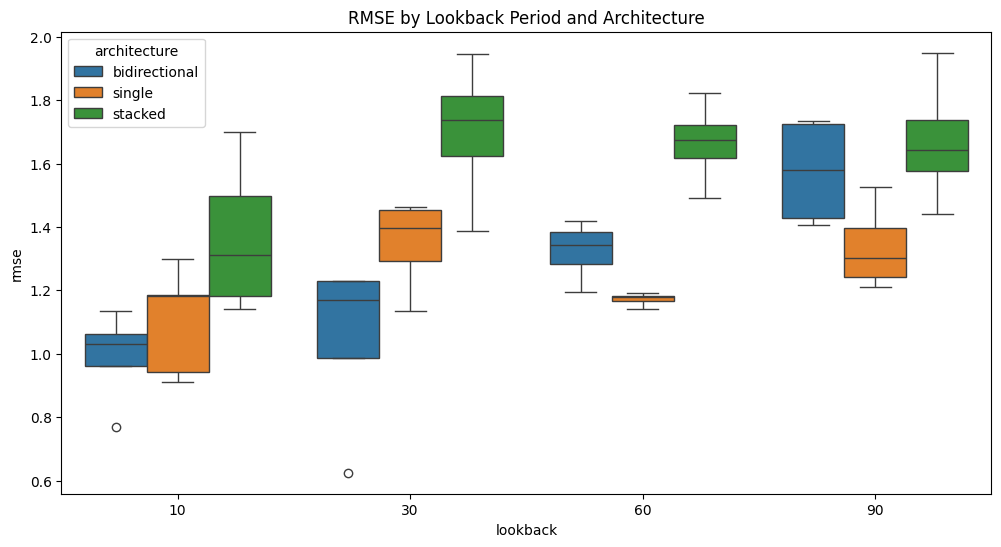

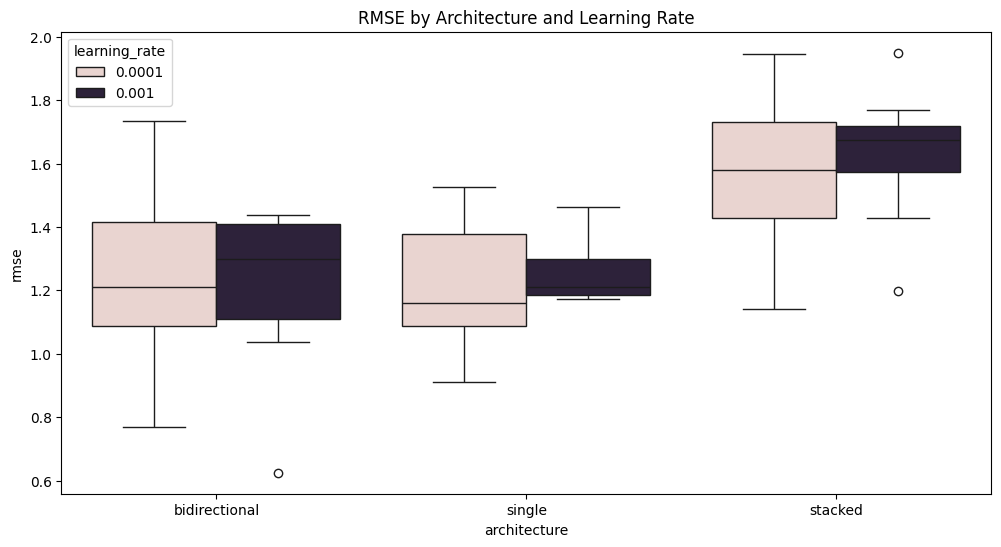

In [18]:
# Display results summary
print("\nTop 5 Configurations:")
print(results_df.head().to_string())

print("\nBest Configuration:")
print(f"Lookback: {best_config['lookback']}")
print(f"Architecture: {best_config['architecture']}")
print(f"Learning rate: {best_config['learning_rate']}")
print(f"Dropout: {best_config['dropout']}")
print(f"Best RMSE: {best_rmse:.4f}")

# Plot results by lookback period and architecture
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='lookback', y='rmse', hue='architecture')
plt.title('RMSE by Lookback Period and Architecture')
plt.show()

# Plot results by learning rate
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='architecture', y='rmse', hue='learning_rate')
plt.title('RMSE by Architecture and Learning Rate')
plt.show()

In [19]:
best_config

{'lookback': 30,
 'architecture': 'bidirectional',
 'learning_rate': 0.001,
 'dropout': 0.2}

In [22]:
results_df.head(50)

,lookback,architecture,learning_rate,dropout,rmse,mae,r2,min_val_loss
21,30,bidirectional,0.0010,0.2,0.624982,0.294311,0.859817,0.002648
11,10,bidirectional,0.0001,0.2,0.769379,0.428431,0.786764,0.004013
4,10,single,0.0001,0.3,0.912400,0.421909,0.700118,0.005644
3,10,single,0.0001,0.2,0.941751,0.569172,0.680514,0.006013
12,10,bidirectional,0.0001,0.3,1.024809,0.475717,0.621674,0.007120
10,10,bidirectional,0.0010,0.3,1.036275,0.516501,0.613162,0.007281
23,30,bidirectional,0.0001,0.2,1.109153,0.469142,0.558488,0.008341
9,10,bidirectional,0.0010,0.2,1.134524,0.494675,0.536332,0.008727
15,30,single,0.0001,0.2,1.136406,0.501558,0.536524,0.008756
27,60,single,0.0001,0.2,1.139820,0.587501,0.536346,0.008808


## Best Model Validation

Let's load the best model and validate it on the test set with detailed metrics and visualizations.

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Best Model Performance:
RMSE: 0.6250
MAE: 0.2943
R2 Score: 0.8598


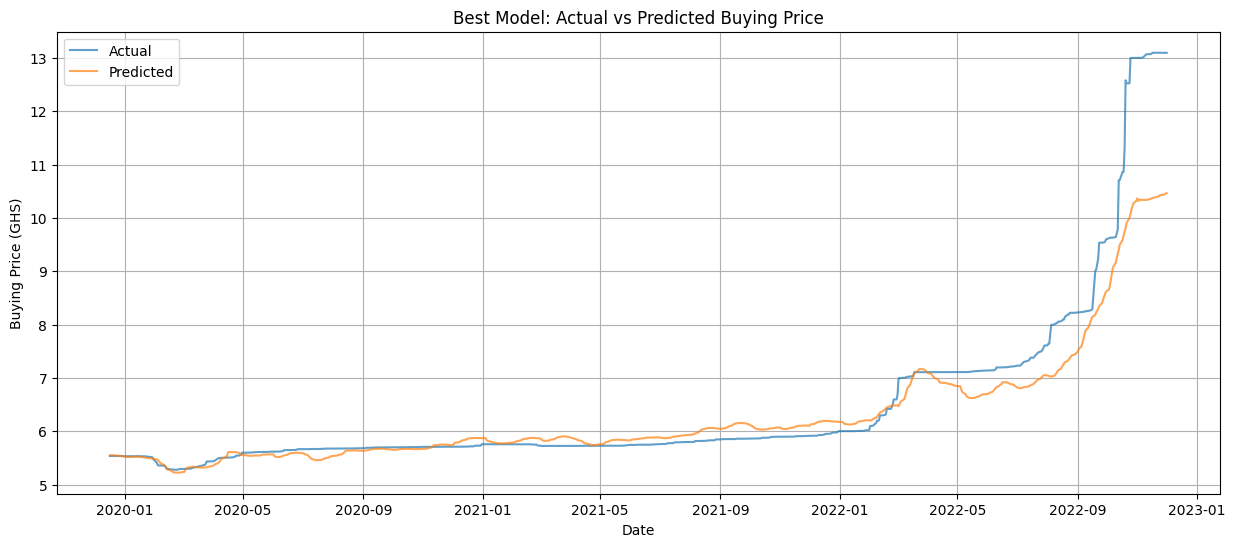

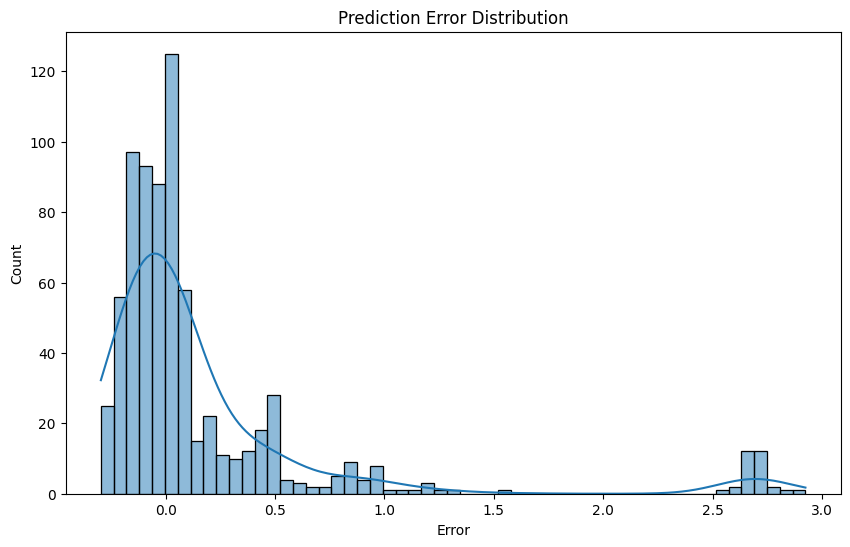

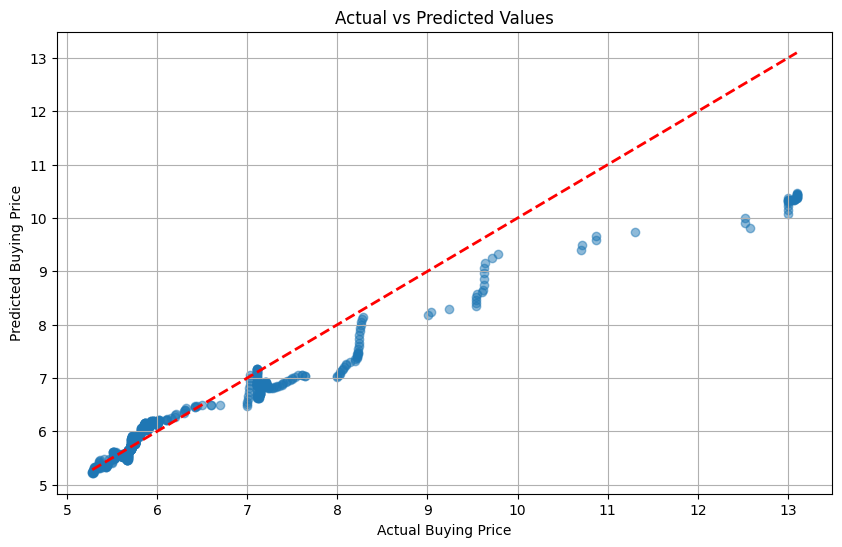

In [24]:
from tensorflow.keras.models import load_model

# Load best model
best_model = load_model('models/lstm_ghs_buying_best.keras')

# Create sequences with best lookback
Xs, ys, idxs = create_sequences(X_scaled, y_scaled, best_config['lookback'])
n_train = int(len(Xs) * TRAIN_RATIO)
X_train, X_test = Xs[:n_train], Xs[n_train:]
y_train, y_test = ys[:n_train], ys[n_train:]
dates_test = dates[idxs[n_train:]]

# Get predictions
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)[:,0]
y_true = scaler_y.inverse_transform(y_test)[:,0]

# Detailed metrics
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Best Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# Plot predictions
plt.figure(figsize=(15,6))
plt.plot(dates_test, y_true, label='Actual', alpha=0.7)
plt.plot(dates_test, y_pred, label='Predicted', alpha=0.7)
plt.title('Best Model: Actual vs Predicted Buying Price')
plt.xlabel('Date')
plt.ylabel('Buying Price (GHS)')
plt.legend()
plt.grid(True)
plt.show()

# Plot prediction error distribution
errors = y_true - y_pred
plt.figure(figsize=(10,6))
sns.histplot(errors, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

# Scatter plot of actual vs predicted
plt.figure(figsize=(10,6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual Buying Price')
plt.ylabel('Predicted Buying Price')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

## Model Training Notes

The hyperparameter tuning tested combinations of:
- Lookback periods: 10, 30, 60, 90 days
- Architectures: 
  - Single LSTM layer (64 units)
  - Stacked LSTM (64 + 32 units)
  - Bidirectional LSTM (64 units)
- Learning rates: 0.001, 0.0001
- Dropout rates: 0.2, 0.3

Additional improvements:
1. Learning rate reduction on plateau
2. Early stopping with best weights restoration
3. Model checkpointing
4. Systematic tracking of all configurations

The best model is saved as `models/lstm_ghs_buying_best.h5`.

In [91]:

import shap
import numpy as np
import matplotlib.pyplot as plt

# Load your best model (assuming keras)
from keras.models import load_model

# CAUTION: SHAP expects access to the SAME feature scaling as when training!
best_model = load_model('models/lstm_ghs_buying_best.keras')


background = X_train[np.random.choice(
    X_train.shape[0], 100, replace=False)]


In [92]:
X_to_explain = X_scaled[:100]

In [122]:
X_to_explain.shape, background.shape

((10, 30, 23), (50, 30, 23))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
5357/5357 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step


 10%|█         | 1/10 [00:27<04:05, 27.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5357/5357 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step


 20%|██        | 2/10 [00:54<03:38, 27.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5357/5357 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step


 30%|███       | 3/10 [01:23<03:16, 28.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
5357/5357 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step


 40%|████      | 4/10 [01:57<03:01, 30.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5357/5357 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step


 50%|█████     | 5/10 [02:28<02:33, 30.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5357/5357 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step


 60%|██████    | 6/10 [03:02<02:07, 31.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5357/5357 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step


 70%|███████   | 7/10 [03:31<01:32, 30.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5357/5357 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step


 80%|████████  | 8/10 [04:01<01:00, 30.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5357/5357 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step


 90%|█████████ | 9/10 [04:31<00:30, 30.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5357/5357 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step


100%|██████████| 10/10 [05:03<00:00, 30.39s/it]


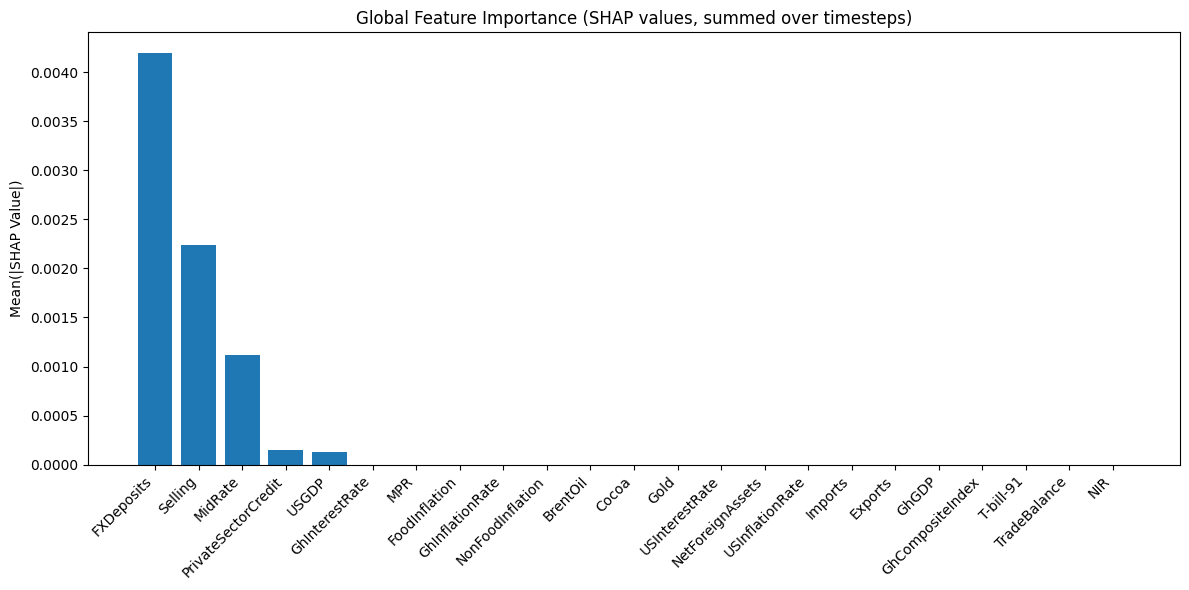

In [123]:
# SHAP KernelExplainer for LSTM (flattened input)
import shap
import numpy as np

# Prepare background and data to explain (flattened to 2D)
background = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]
background_2d = background.reshape(background.shape[0], -1)
X_to_explain = X_test[:10]
X_to_explain_2d = X_to_explain.reshape(X_to_explain.shape[0], -1)

# Define prediction function for KernelExplainer
# (reshapes 2D input back to 3D for the LSTM model)
def predict_fn(x):
    n_features = X_train.shape[2]
    timesteps = X_train.shape[1]
    batch_size = x.shape[0]
    x_reshaped = x.reshape(batch_size, timesteps, n_features)
    pred = best_model.predict(x_reshaped)
    return pred.reshape(batch_size, -1)

# Create SHAP KernelExplainer
explainer = shap.KernelExplainer(predict_fn, background_2d)
shap_values = explainer.shap_values(X_to_explain_2d)

# For visualization, you can reshape or average as needed
# Example: mean absolute SHAP value per feature (averaged over timesteps)
n_features = X_train.shape[2]
timesteps = X_train.shape[1]
shap_arr = shap_values[0] if isinstance(shap_values, list) else shap_values
shap_arr_3d = shap_arr.reshape(X_to_explain.shape[0], timesteps, n_features)
feature_importance = np.abs(shap_arr_3d).mean(axis=(0, 1))

# Get feature names
feature_cols = [c for c in df_reduced.columns if c not in ['Date', 'Buying']]

# Plot feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sorted_idx = np.argsort(feature_importance)[::-1]
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
plt.xticks(range(len(feature_importance)), np.array(feature_cols)[sorted_idx], rotation=45, ha='right')
plt.title('Global Feature Importance (SHAP values, summed over timesteps)')
plt.ylabel('Mean(|SHAP Value|)')
plt.tight_layout()
plt.show()


In [ ]:
best_config = {'lookback': 30,
               'architecture': 'bidirectional',
               'learning_rate': 0.001,
               'dropout': 0.2}

In [ ]:
best_config

{'lookback': 30,
 'architecture': 'bidirectional',
 'learning_rate': 0.001,
 'dropout': 0.2}